# Model & Conclusions

In [1]:
import pandas as pd
import numpy as np

## Importing dataset

In [2]:
BASE = "ds_tastingmovies"
ds_tastingmovies = pd.read_pickle("data/" + BASE + ".pkl")

X = ds_tastingmovies.drop('high_rating', axis=1)

y = ds_tastingmovies['high_rating']

- Quick view

In [73]:
X.head()

,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,...,Musical_avg_rtng_acum_prev,Mystery_avg_rtng_acum_prev,Sci-Fi_avg_rtng_acum_prev,Thriller_avg_rtng_acum_prev,Western_avg_rtng_acum_prev,Action_avg_rtng_acum_prev,Comedy_avg_rtng_acum_prev,Fantasy_avg_rtng_acum_prev,Romance_avg_rtng_acum_prev,War_avg_rtng_acum_prev
0,0,0,1,1,1,1,0,0,0,1,...,NaN,5.00,4.35,4.71,3.0,4.60,4.79,5.00,5.00,5.00
1,0,0,1,1,1,1,0,0,0,1,...,3.17,3.38,3.07,3.00,3.0,2.96,3.42,3.53,3.47,3.80
2,0,0,1,1,1,1,0,0,0,1,...,NaN,NaN,5.00,5.00,NaN,5.00,5.00,5.00,NaN,NaN
3,0,0,1,1,1,1,0,0,0,1,...,4.64,4.33,4.54,4.63,4.5,4.50,4.63,4.69,4.56,4.38
4,0,0,1,1,1,1,0,0,0,1,...,NaN,NaN,5.00,5.00,NaN,5.00,5.00,5.00,5.00,5.00


 - Importing function to split dataset in train-test samples

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


Libraries for:

<br>

   - Hyperparameter tuning: *hyperopt* for a Bayesian Optimization
   - Machine learning techquine: *xgboos* for XGBoosting 
   - For metrics: accuary, roc/auc and log loss from sklearn package
   

In [5]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### The definition of the space to explore for the hyperparameter's search:

In [6]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

### The objetive function to optimize through the hyperparameter:

In [7]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [8]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/jalfredomb/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                 
0.6496879875195007                                     
SCORE:                                                                            
0.6504680187207488                                                                
SCORE:                                                                            
0.6560842433697348                                                                
SCORE:                                                                            
0.6574882995319813                                                                
SCORE:                                                                            
0.6567082683307333                                                                
SCORE:                                                                            
0.6500780031201248                                                                
SCORE:                                                    

0.6631825273010921                                                                 
SCORE:                                                                             
0.6569422776911077                                                                 
SCORE:                                                                             
0.6599063962558502                                                                 
100%|██████████| 100/100 [02:53<00:00,  1.73s/trial, best loss: -0.6664586583463339]


In [9]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9199211682071172, 'gamma': 2.84438361684429, 'max_depth': 7.0, 'min_child_weight': 10.0, 'reg_alpha': 41.0, 'reg_lambda': 0.7577169489054644}


### Adjusting the model

- Once with the best hyperparameteres found, we fit a model with them with the **XGBClassifer**

In [10]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(max_depth = int(best_hyperparams['max_depth']),
                            gamma = best_hyperparams['gamma'],
                            min_child_weight = best_hyperparams['min_child_weight'],
                            colsample_bytree = best_hyperparams['colsample_bytree']
                            )

classifier.fit(X_train, y_train)

[10:35:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9199211682071172,
              gamma=2.84438361684429, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=10.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [11]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
CrossValMean = accuracies.mean()

/Users/jalfredomb/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

In [12]:
print("Applying k-Fold Cross Validation (Mean): ", CrossValMean)

Applying k-Fold Cross Validation (Mean):  0.6728738801073452


In [13]:
best_hyperparams['max_depth']=int(best_hyperparams['max_depth'])
best_hyperparams['n_estimators'] = 4000
xgb = XGBClassifier(**best_hyperparams)
xgb.fit(X_train, y_train, eval_metric=['logloss'],verbose=100, early_stopping_rounds=100,
        eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.64871	validation_1-logloss:0.65011
[100]	validation_0-logloss:0.56526	validation_1-logloss:0.59141
[126]	validation_0-logloss:0.56462	validation_1-logloss:0.59131


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9199211682071172,
              gamma=2.84438361684429, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=10.0, missing=nan,
              monotone_constraints='()', n_estimators=4000, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=41.0, reg_lambda=0.7577169489054644, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [14]:
pred_val = xgb.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_val)
auc_test = roc_auc_score(y_test, pred_val)
logloss_test = log_loss(y_test, pred_val)

print('>> The Accuracy on test sample is ' + str(accuracy_test))
print('')
print('>> The Area under the ROC Curve on test sample is ' + str(auc_test))
print('')
print('>'*6 +'>>> Therefore the gini on test sample is ' + str(2*auc_test-1))
print('')
print('>> The Logloss on test sample is ' + str(logloss_test))

>> The Accuracy on test sample is 0.6911076443057722

>> The Area under the ROC Curve on test sample is 0.6061306690450183

>>>>>>>>> Therefore the gini on test sample is 0.21226133809003667

>> The Logloss on test sample is 10.668954172886972


- Saving this version:

In [16]:
import pickle
filehandler = open('data/xgb_movies_model_v01.pkl',"wb")
pickle.dump(xgb,filehandler)
filehandler.close()

- The first thing to say is that evidentely the model is not a strong one, the perfomance is not that good actualy. 

- This could mean that the dataset has to much noise and we could use some extra-cleaning work and maybe remove some features. On the other hand, the minum frequency of tag's apperence parameter could be being to much demanding causing the lost of registers that would be helpful to the model's traing

- Nevertheless, lets check out what this model learned and which variables are being more relevant

## Feature Importance

In [17]:
import shap

In [18]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

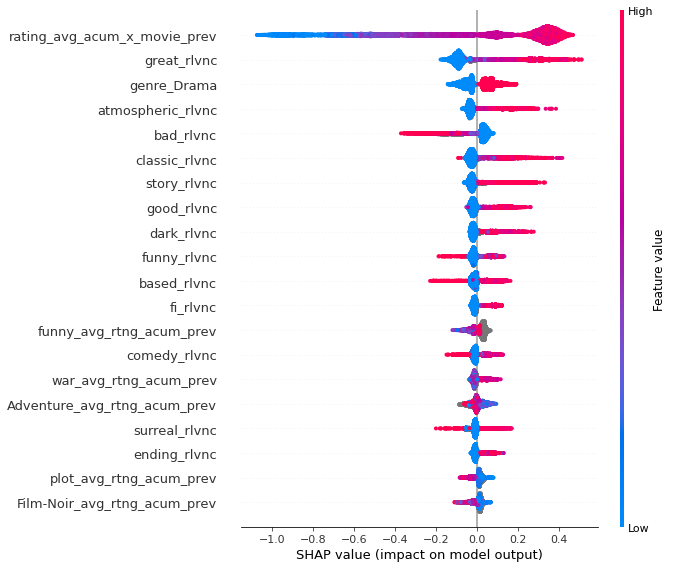

In [19]:
shap.summary_plot(shap_values, X_test)

### Feature interpretability

Lets go with the most important ones:

#### 1. Movie's cumulative averange rating until last (previus) user's review
> rating_avg_acum_x_movie_prev

- Firs of all, we can see that the mayority of the observations for this variable are on the positive side, in order words, the highest density is on the high ratings as we can see from the red plumpy side of the chart.

- This is the most relevant variable and it make sense, since, many times, when we are going to see a movie on streaming on even in the movie cinemas, the current (on that moment before we see it) rating, opinions or even reviews of it plays a rol in our heads and it even biass us and, therefore, our final opinion of it, ussualy on the same direction. . Even for some people that consider itself like they are not like everyone else and asure that they not get contagious with the else's perspective, even that previos external-opinion could influence his/her final rating of the movie from a indirectal kind of way, beacause the predisposicion in this case would be to do the oppositve of what is said, so when it is a bad movie, according with the general saying, he or she could take that into an unconscious consideration and give a final high rating.

- The relation of this variable with the movies' approval is directly proportional and we know this because the red values are with the positive shap values and the blue ones with the negative shap values and it means that when the previus cumulative mean of the movie rating (just before the new person sees it) is high, the final rating of that person it is likely to go up also and, when the previus cumulative rating is low, the more sure thing to be is that the final new person's rating is going to be down too.

- In this case, the variable plays a stronger influence when it takes low values than when it takes the high ones. We can see this since how the bar extends to much to the left until it gets blue and that does not happen withthe red side of the bar, therefore the positive opinion is not that influencial. What this is telling us is that it is a lot more sure that the new person is going to rate the movie with a disapproving number (low) if that movie has an previuos bad rating and it is not that sure that he/she rates it with a high rate if the movie cames pre-approved. In other words, if the people says that the movie is bad, the new person will (most likely) agree to it and if the world says that the movie is very good, the person is not going to desagree without seeing it before but he/she is not going to assure that before he/she gets his/her own opinion.


#### 2. The relevance of the tag 'great' on the movie (& 'atmospheric')
> great_rlvnc
- The second-most important variable.

- All of this also happens for the variable relevance of the tag 'atmospheric' on the movie
   
         > atmospheric_rlvnc
           
- Most dense on the low values, but very influencial on the high ones and since it is a variable with a directly proportional relationship, this mean that when a movie to much associate with the tag 'great', the person most likely say that about the movie and approve it too.

           
- In both cases when the relevance of this tag increases, it also increases (and very much) the probability that the user approve that movie. Which it does not mean that, for the low values, the person will not approve the movie. For those cases, the variable does not hace to much power.




#### 3. If the movie's genre is Drama
> genre_Drama
- This variable impresses me. And it is so because it seems to be very important for both values that it takes, those being: *It is a drama movie* & *It is not a drama movie*. And the way this variables does that is, since it has a directly relationship with the approval criteria,  when the movie is not a drama, the variable plays a important rol to indentify the ones that do not approve the movie, but it is also very usefull on the other side, it being, when the movie is a drama, this variable helps with a non insignificance importance to identify the users that would give a high rating to the movie. This becomes to the variable into a great compass for the north and for the south (ok, this is not technicaly right but you sure get my point :P )


#### 4. The relevance of the tag 'bad' on the movie

- This variable is very important, because from the ones of the top, it is the only one that has a indirectly relationship with the objective variable and we can notice this since the high values of this one, i.e. the 1's, are inline with the negatives shap values and the zero for this variable goes with the possitives shap values, meaning that, when this variable is activated `bad_rlvnc==1` the most likely thing to be is that the next rating is going to be a low one and this is confirmed with the large of the red side of the bar, which is not that short as the blue part of the same one . What this is telling us is that if the movie does have this tag associate as relevant, we could be pretty sure that he next rating is going to be low. This variable does not have that same power on the other side, meaning that even though the variable suggest that if it has not the 'bad' tag relevante, the movie is going to be a well ranked one, it cannot be taken as a sure thing, it could be but not as that confident.


#### An eye on a particular case

Lets see what happen with the importance of our predictors over a real case from the test dataset

In [25]:
row_to_show = 5 #len(y_test) -1
data_for_prediction = X_test.iloc[row_to_show] 
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


xgb.predict_proba(data_for_prediction_array)

array([[0.18263453, 0.81736547]], dtype=float32)

- In this case, base on the fact that the probability is higher than 50%, the model is predicting a high rating for this movie (`high rate estimated==1`)

In [35]:
k_explainer = shap.KernelExplainer(xgb.predict_proba, X_test)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

Using 12820 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


- In this case we are whatching the most influence variables *'playing'* for this particular case, in which the variables that are provinding more 'guide' in order to make a prediction are the ones that are 'pushing' the prediction to be higher, therefore the estimation in this case is that the user is going to approve the movie, in order words, rating it high

- Lets check which is the real value for this case for the `high_rating` variable:

In [44]:
y_test.iloc[5]

1

**Our prediction is correct!!**

- Now, just let see if our way to interpreter the feature importance, make sense for this case

In [72]:
X_test[['rating_avg_acum_x_movie_prev','genre_Drama','great_rlvnc','bad_rlvnc']].iloc[5,]

rating_avg_acum_x_movie_prev    4.195652
genre_Drama                     1.000000
great_rlvnc                     0.000000
bad_rlvnc                       0.000000
Name: 20576, dtype: float64

- Rookie mistake: forgot to put the id on the data set for training, but, since we did the random split with a seed, we can replicate the samples split with the same seed on the dataset complete to see what movie is it and comment about if the prediction makes or does not make sense

In [48]:
BASE = "tbl_usrmovie_t0"
tbl_usrmovie_t0 = pd.read_pickle("data/" + BASE + ".pkl")

X_compleate = tbl_usrmovie_t0.drop('high_rating', axis=1)

y_compleate = tbl_usrmovie_t0['high_rating']


from sklearn.model_selection import train_test_split

X_train_compleate, X_test_compleate, y_train_compleate, y_test_compleate = train_test_split(X_compleate, y_compleate, test_size = 0.3, random_state = 0)

In [69]:
movie = pd.read_csv('data/'+'movie'+'.csv',header=0, dtype = {"title" : "str","movieId" : "str"})
pd.merge(X_test_compleate.head(6),movie,on='movieId',how='left')[['movieId','title','genres','rating_usr','rating_avg_acum_x_movie_prev','genre_Drama','great_rlvnc','bad_rlvnc']].tail(1)

,movieId,title,genres,rating_usr,rating_avg_acum_x_movie_prev,genre_Drama,great_rlvnc,bad_rlvnc
5,46578,Little Miss Sunshine (2006),Adventure|Comedy|Drama,4.0,4.195652,1,0.0,0.0


- It has a previous rating cumulative averange *'high'* (makes sense with our model that estimated a high rating also) 

- It is a Drama movie (which makes a lot of sense with our hypothesis that the variable *'genre_Dama'* when it is activated, i.e. taking de value of 1, it helps very much to identify the high ratings )

- It has not the *'great'* tag as relevant associate, which goes also with our final comment of that variable that says that, the no-pressence of that variable (`great_rlvnc==0`) does not asure that the movie would have a low rating

- It does not have the *'bad'* tag as relevant associate, which also makes sense since even that it has a lot of importance when the variable is activated (`bad_rlvnc==1`) almost asuring that, in those cases, the movie is going to be ranked as bad, when the variable is not activated, like in this case, it could be that the movie is going to be ranked as high, without assuring it, but as in this case, being right about it also.


- And last, IT IS CERTAINLY A GREAT MOVIE! I would have ranked it with the highest possible. Abigail Breslin and Alan Arkin rocked the world. 

PS. Sorry for the personal *'tweet'*, something a movie fan can not help it :) 

## Next steps

The model *'works'* but has a low performance and there could be many things that may help to improve it. Some of those I suggest are:

- Changing the minum number of times that a word appears on the tags, may help to have more variables that could help but also and more important, it would imply to have more registers from which the model can learn.

- Either with it or without the 'new' words, the dataset could use some extra cleaning previuos to the tuning and traing part. I would have implement some entropy and correlations analysis in order to identify some of the features that are load with trash and that, far to help, harm the training of the model because it could get distracted with all that junk variables

- For this version of the model, in order to deliver on time the priority was take the most advantage of the data already given, but for the next version of this model a good idea could be to look for more data sources such as the external ones that suggested in the challenge.

- I would wanted also train other models that compite with different hyperparameters and also different ML techniques in order to see if some of those acomplish some better understanding of the user's prefferences in movie taste
